In this notebook, we will be continuing to explore the remaining features and evaluate their feasibility towards helping us in finalising the our explicitly derived ratings that can be eventually used in our modelling stage

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

In [4]:
recco = pd.read_parquet('/content/drive/MyDrive/Steam games dataset/sample_recommendations_filter.pq')
app_list = pd.read_csv("/content/drive/MyDrive/Steam games dataset/app_list_v2.csv")

In [4]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [5]:
recco.dtypes

app_id              int32
user_id             int32
helpful             int32
funny               int32
date               object
is_recommended       bool
hours             float64
review_id           int32
products            int32
reviews             int32
title              object
date_release       object
win                  bool
mac                  bool
linux                bool
rating             object
positive_ratio      int32
user_reviews        int32
price_final       float64
price_original    float64
discount          float64
steam_deck           bool
description        object
tags               object
dtype: object

In [6]:
app_list.isnull().sum()

appid                  0
name                  11
developer            213
publisher            139
score_rank         59560
positive               0
negative               0
userscore              0
owners                 0
average_forever        0
average_2weeks         0
median_forever         0
median_2weeks          0
price                 29
initialprice          22
discount              22
ccu                    0
dtype: int64

In [7]:
def var_hist(df, col, rows, cols, bin):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 15))
    axes = axes.flatten()
    for i, coln in enumerate(col):
        sns.histplot(x=df[coln], ax=axes[i], bins=bin)
        axes[i].set_title(f'Distribution of {coln}')
        plt.ticklabel_format(style='plain', axis='both')
    plt.tight_layout()
    plt.show()

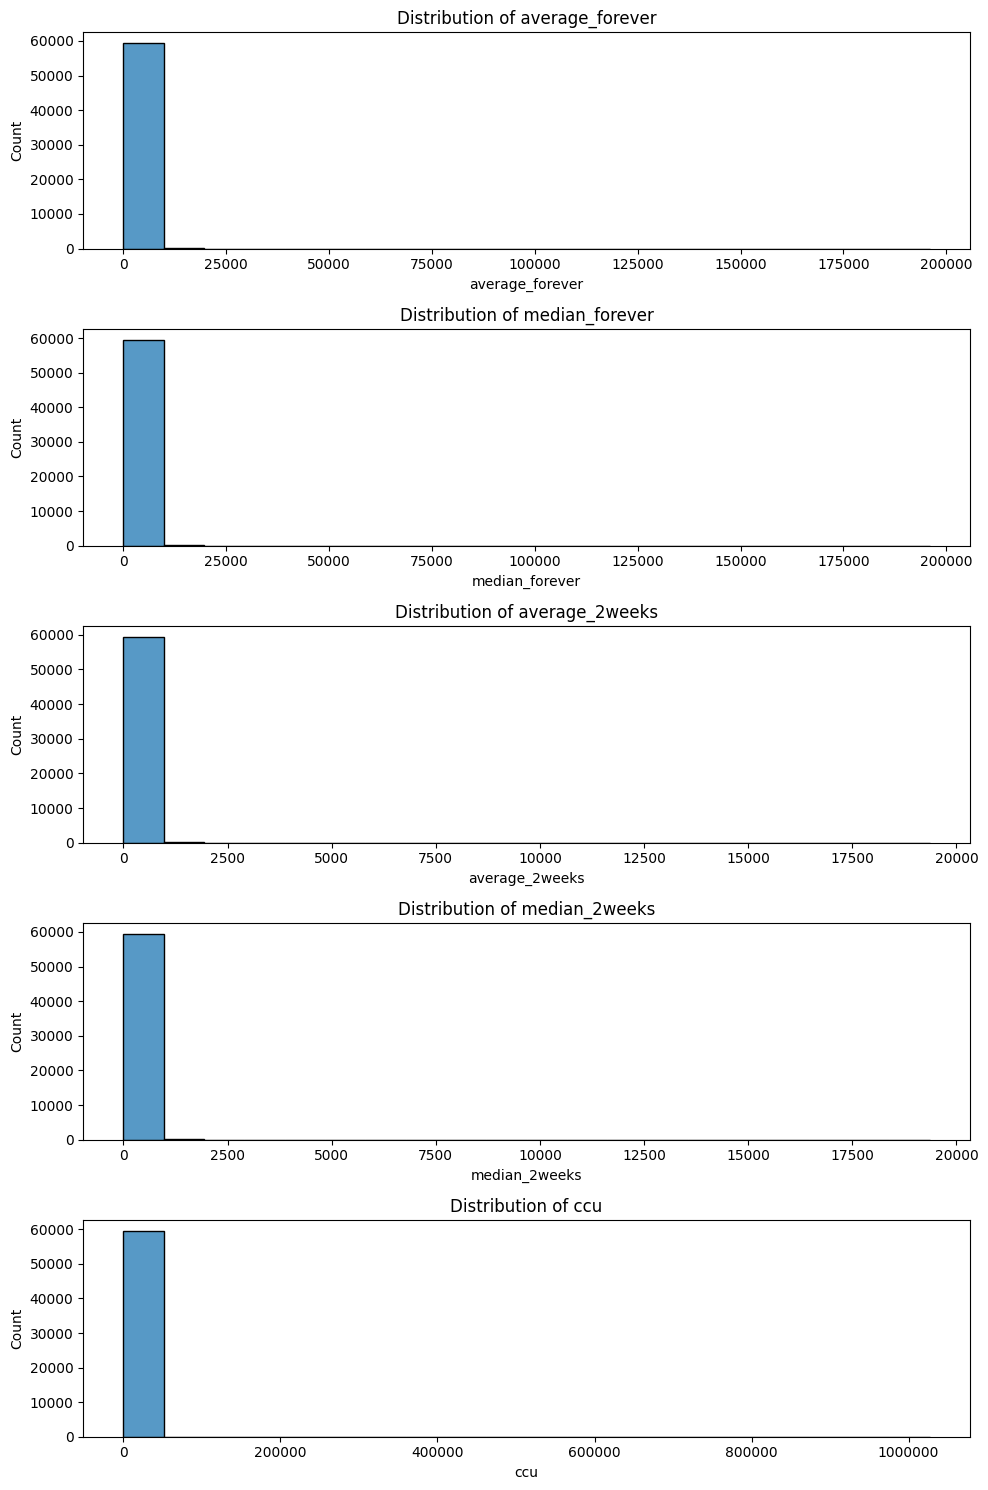

In [8]:
var_hist(app_list, ['average_forever', 'median_forever', 'average_2weeks', 'median_2weeks', 'ccu'], 5, 1, 20)

It can be observed that the average and median playtime across 2 weeks as well as throughout are more or less relatively similar in all games. This implies that most users do not spend a huge amount of time in their daily lives gaming, as only a small handful are having exceedingly long playtime duration 

Text(0, 0.5, 'Frequency')

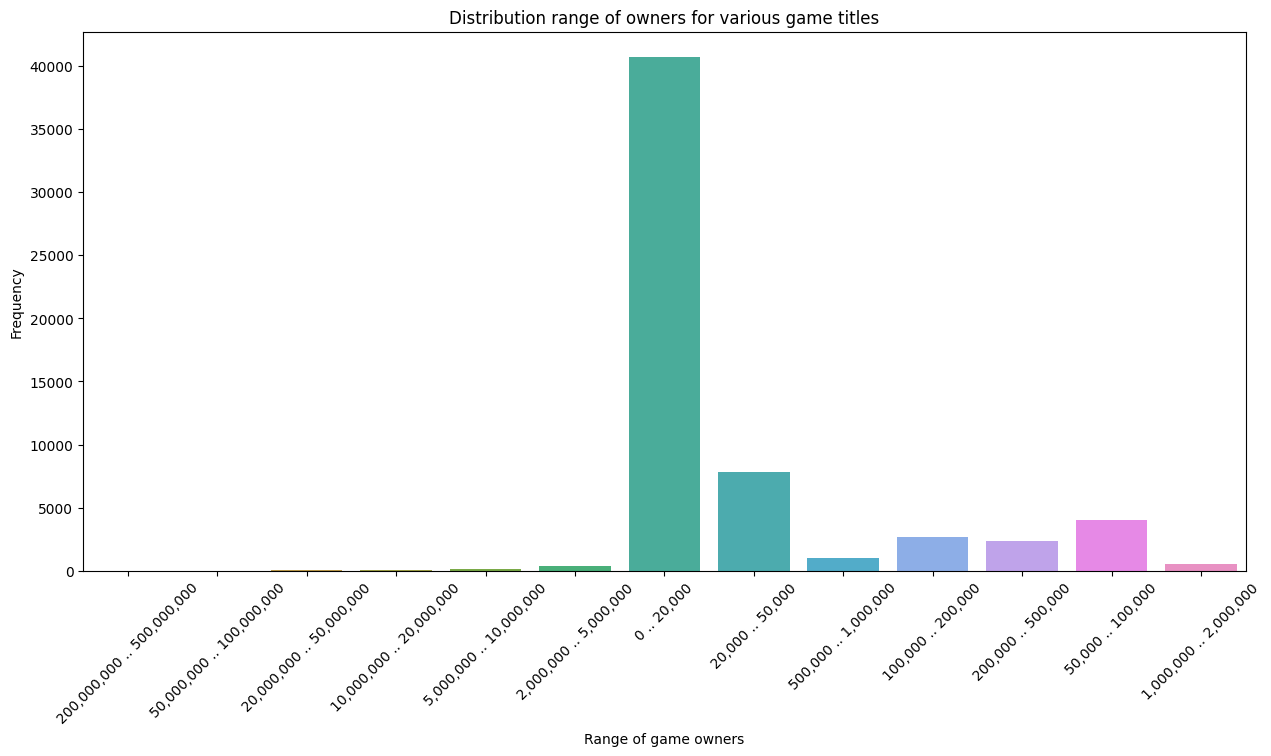

In [9]:
plt.figure(figsize=(15, 7))
sns.countplot(data=app_list, x='owners');
plt.title('Distribution range of owners for various game titles')
plt.xlabel('Range of game owners')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

We can see that most games in steam library are not owned by many owners

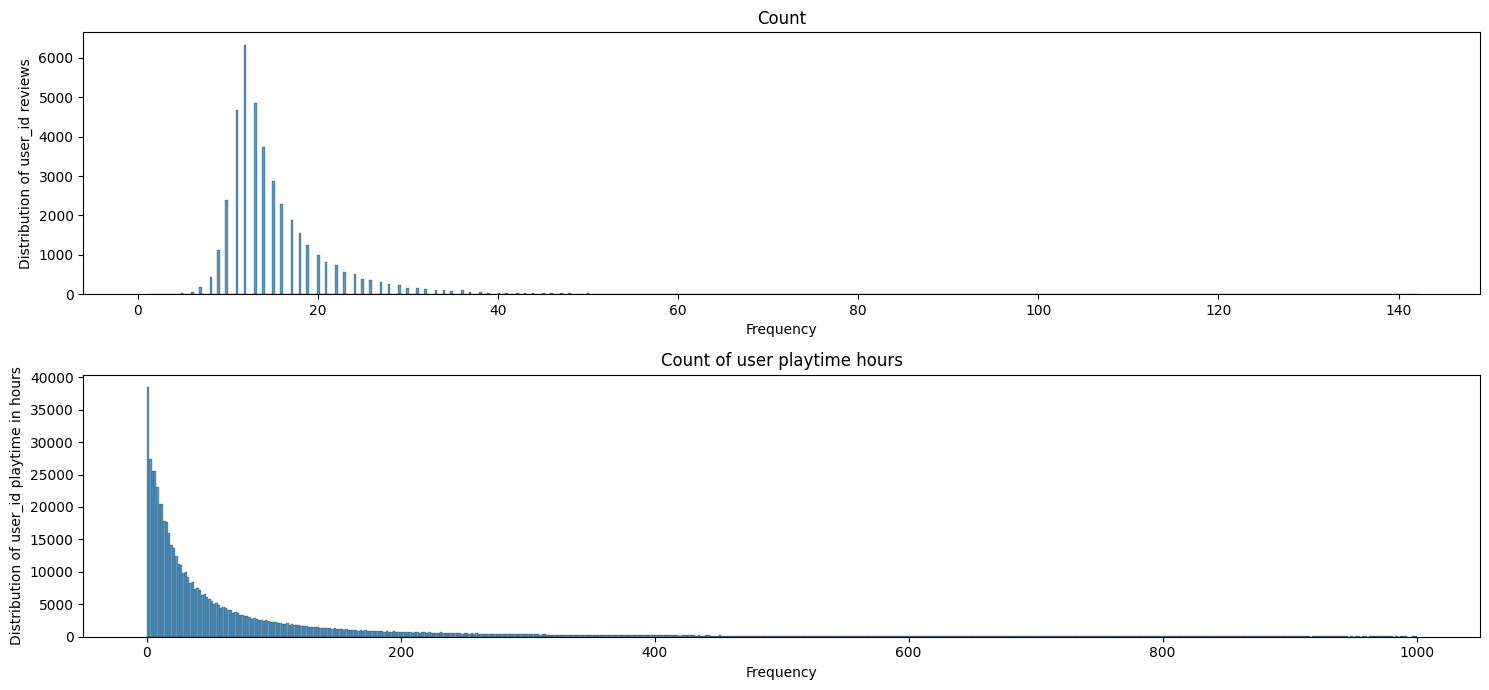

In [5]:
counts = recco['user_id'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
sns.histplot(data=counts, ax=ax[0]);
ax[0].set_title('Count')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Distribution of user_id reviews')

#assumed_ratings are used for continuous predictions and regression models



sns.histplot(data=recco, x='hours', ax=ax[1]);
ax[1].set_title('Count of user playtime hours')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Distribution of user_id playtime in hours')

plt.tight_layout()
plt.show()

Similarly, We can see that most individual users do have long playtime hours in the respective games that they have played as supoorted by our claim earlier. Also after reducing the sample size of the original recommendations dataset, we noticed that most users do not review many games

In [11]:
recco['hours'].describe()

count    626490.000000
mean         87.111953
std         146.438170
min           0.100000
25%          10.900000
50%          31.400000
75%          90.700000
max         999.900000
Name: hours, dtype: float64

In [12]:
counts.describe()

count    40457.000000
mean        15.485330
std          6.744914
min          1.000000
25%         12.000000
50%         14.000000
75%         17.000000
max        142.000000
Name: user_id, dtype: float64

## Feature Engineering

- Since there are no direct continuous(explicit) ratings for the dataset and steam web regarding the feedback from users about the various games, we will be using the users playtime feature to infer these ratings, by quantifying on the assumption that if a user plays the game for a long time, they will enjoy that specific game. 

- Based on the earlier analysis of other features, we noticed that most of the playtime features are skewed towards the left with most users do not have long playtime hours across most games. Instead, there are some outlying data from users having extremely long playtime of up to almost 1000 hours in total.

- This information can be attributed that some of these games, varying from genre and nature of the game titles, can result in a variable range of playtime hours across users. Hence, we need to utilise transformation techniques that can account for this phenomena, as well as ensuring that the final distribution of the feature is relatively closer towards resembling a normal distribution.

- To do this, we will be performing binning transformation by grouping the users' playtime into 10 different bins, and rank them to a scale of [1,5]

In [6]:
# bin user playtime into 5 intervals using cut
recco['playtime_bin'] = pd.cut(recco['hours'], bins=10, labels=False) + 1

# assign ranks based on playtime_bin_cut
recco['rank_ratings'] = recco.groupby('playtime_bin')['hours'].rank(method='dense', ascending=True)
recco['rank_ratings'] = (recco['rank_ratings'] - 1) / (recco['rank_ratings'].max() - 1) * 4 + 1

In [7]:
recco['rank_ratings'].describe()

count    626490.000000
mean          2.262174
std           1.076877
min           1.000000
25%           1.364364
50%           1.936937
75%           2.965966
max           5.000000
Name: rank_ratings, dtype: float64

In [8]:
print('Skewness before binning transformation: ', skew(recco['hours']))
print('Kurtosis before binning transformation: ', kurtosis(recco['hours']))
print('Skewness after binning transformation: ', skew(recco['rank_ratings']))
print('Kurtosis after bininng transformation: ', kurtosis(recco['rank_ratings']))

Skewness before binning transformation:  3.168428252911304
Kurtosis before binning transformation:  11.401144566273455
Skewness after binning transformation:  0.8245705482147313
Kurtosis after bininng transformation:  -0.39784188891015226


- Skewness and Kurtosis are both measures of the shape of probability distribution. Skewness refers to the symmetry of the distribution, while kurtosis refers to the length of distribution peak and tail width. 

- A normal distribution is commonly defined to have a skewness range of [-1,1], and not having a kurtosis value of more than 3 which signifies a greater likelihood of outliers.

- After binning transformation, we have observed that the users playtime distribution is now closer towards a normal distribution based on its skewness and kurtosis values. We are now able to use these newly engineered feature ratings in our collaborative modelling later on

In [9]:
recco.drop(columns='playtime_bin', inplace=True)

Text(0, 0.5, 'Count of ratings')

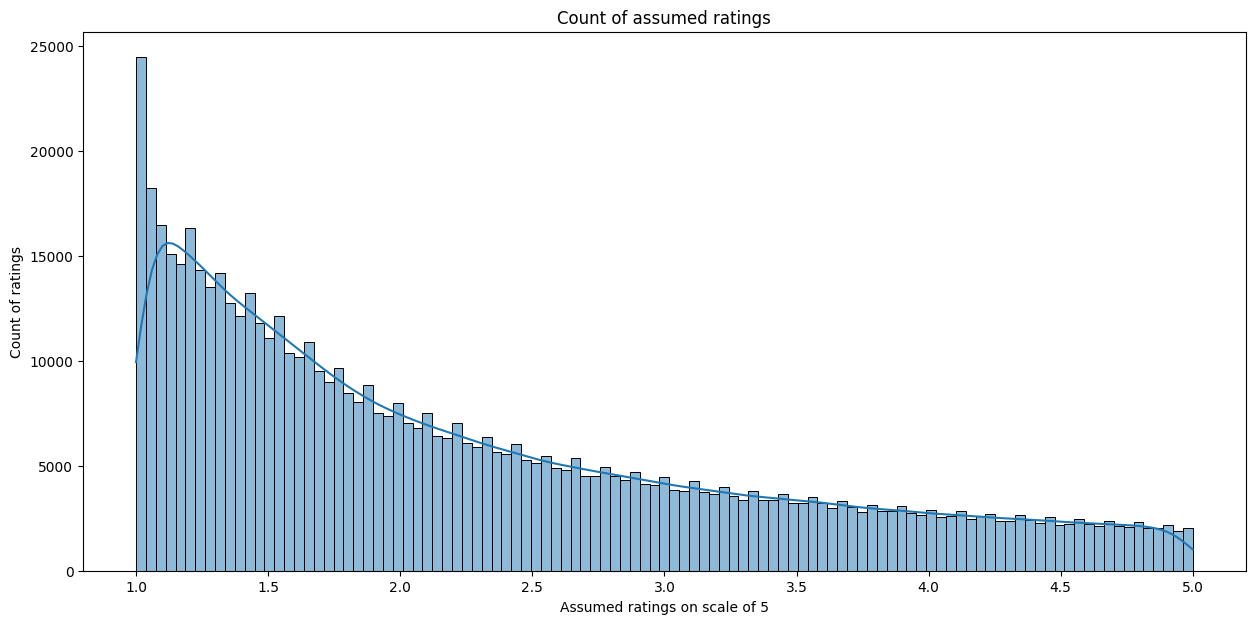

In [10]:
plt.figure(figsize=(15, 7))
sns.histplot(data=recco, x='rank_ratings', kde=True);
plt.title('Count of assumed ratings')
plt.xlabel('Assumed ratings on scale of 5')
plt.ylabel('Count of ratings')

Our histogram is now showing a distribution that is more representative of a normal distribution

To determine the optimal threshold when computing the precion@k and recall@k during our modelling, we will use the median assumed ratings to be our threshold in order to take into account of users likability across individual games

In [20]:
#save the app_list dataframe into new file to be used for NLP content recommender modelling in notebook 3
app_list.rename(columns={"appid": "app_id"}, inplace=True)
app_playtime = app_list[['app_id', 'developer', 'publisher']]

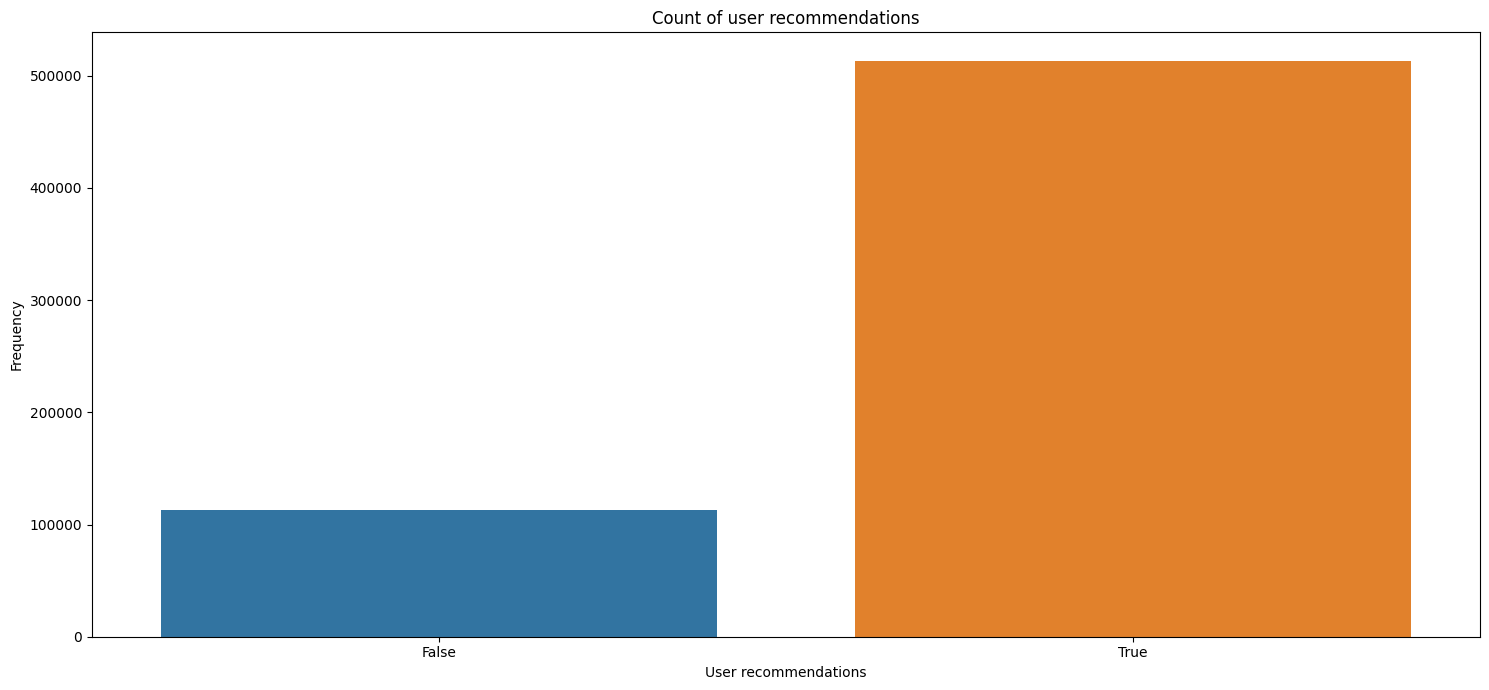

In [21]:
plt.figure(figsize=(15, 7))
sns.countplot(data=recco, x='is_recommended');
plt.title('Count of user recommendations')
plt.xlabel('User recommendations')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Distribution of reviews are mostly skewed towards positively recommended for future users, which imply that most users enjoy the games they are playing

In [22]:
#check no. of unique users in dataset
recco['user_id'].nunique()

40457

In [23]:
recco.to_parquet('/content/drive/MyDrive/Steam games dataset/sample_recommendations_FE_filter.pq', index=False)

In [24]:
app_playtime.to_parquet('/content/drive/MyDrive/Steam games dataset/app_details.pq', index=False)